# Paunoiu Darius Alexandru Tema 2 ML

## Imports and constants

In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset

from models.cnn import ECG1DCNN
from models.mlp import MLP
from utils.data_utils import (get_train_test_tensors, plot_confussion_matrix,
                              plot_loss)
from utils.models_utils import MyTrainer

# CONSTANTS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)
BATCH_SIZE = 64
EXTRA_TRAINER_PARAMS = {
    "optimizer": "Adam",
    "epochs_no": 80,
}

# save_paths stack
save_paths = [
    "figs/Train_Loss_MLP_Patients_adam.png",
    "figs/MLP_Patients_conf_matrix_adam.png",
    "figs/Train_Loss_MLP_ECG_adam.png",
    "figs/MLP_ECG_conf_matrix_adam.png",
    "figs/Train_Loss_CNN_Patients_adam.png",
    "figs/CNN_conf_matrix_adam.png",
]

cuda


## ECG dataset

In [2]:
df_normal = pd.read_csv("ptbdb_normal.csv", header=None)
df_abnormal = pd.read_csv("ptbdb_abnormal.csv", header=None)

# Split into train, validation, test
df_normal_train = df_normal[: int(0.8 * len(df_normal))]
df_normal_test = df_normal[int(0.8 * len(df_normal)) :]

df_abnormal_train = df_abnormal[: int(0.8 * len(df_abnormal))]
df_abnormal_test = df_abnormal[int(0.8 * len(df_abnormal)) :]

# Add normal and abnormal data together
df_train = pd.concat([df_normal_train, df_abnormal_train])
df_test = pd.concat([df_normal_test, df_abnormal_test])

# Shuffle data
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)

In [3]:
display(df_train.head())

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.777778,0.254091,0.113695,0.040482,0.000000,0.067183,0.144703,0.159345,0.161068,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.989315,0.632307,0.166562,0.038341,0.081710,0.172847,0.223130,0.245129,0.235072,0.235072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.408271,0.000000,0.124072,0.495228,0.599152,0.622481,0.630965,0.626723,0.641569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.968941,0.615486,0.329396,0.205162,0.088364,0.111111,0.143045,0.137358,0.137358,0.146107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.971736,0.646030,0.233513,0.039704,0.077389,0.510094,0.558546,0.602961,0.584791,0.625168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
# Convert dataframes to tensors
X_train = torch.tensor(df_train.iloc[:, :-1].values, dtype=torch.float32).unsqueeze(1)
y_train = torch.tensor(df_train.iloc[:, -1].values, dtype=torch.long)
X_test = torch.tensor(df_test.iloc[:, :-1].values, dtype=torch.float32).unsqueeze(
    1
)  # Add channel dimension
y_test = torch.tensor(df_test.iloc[:, -1].values, dtype=torch.long)

# Create dataloaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_train, y_train)
test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## CNN

In [5]:
# Initialize model and train
classifier = ECG1DCNN().to(device)
myTrainerCNN = MyTrainer(
    classifier,
    train_loader,
    train_dataset,
    test_loader,
    test_dataset,
    **EXTRA_TRAINER_PARAMS
)
best_model_wts, train_losses = myTrainerCNN.train_model()

Epoch 10/80
----------
epoch train loss: 0.0002 Acc: 99.5189
Epoch 20/80
----------
epoch train loss: 0.0001 Acc: 99.8368
Epoch 30/80
----------
epoch train loss: 0.0001 Acc: 99.8454
Epoch 40/80
----------
epoch train loss: 0.0000 Acc: 99.9570
Epoch 50/80
----------
epoch train loss: 0.0000 Acc: 100.0000
Epoch 60/80
----------
epoch train loss: 0.0000 Acc: 99.9914
Epoch 70/80
----------
epoch train loss: 0.0000 Acc: 99.9570
Epoch 80/80
----------
epoch train loss: 0.0000 Acc: 100.0000


In [6]:
myTrainerCNN.load_wts(best_model_wts)
predictions, labels = myTrainerCNN.test_model()

In [7]:
accuraccy, precision, recall, f1 = myTrainerCNN.metrics_calculator(predictions, labels)
print(f"Accuracy: {accuraccy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


CNN conf matrix adam


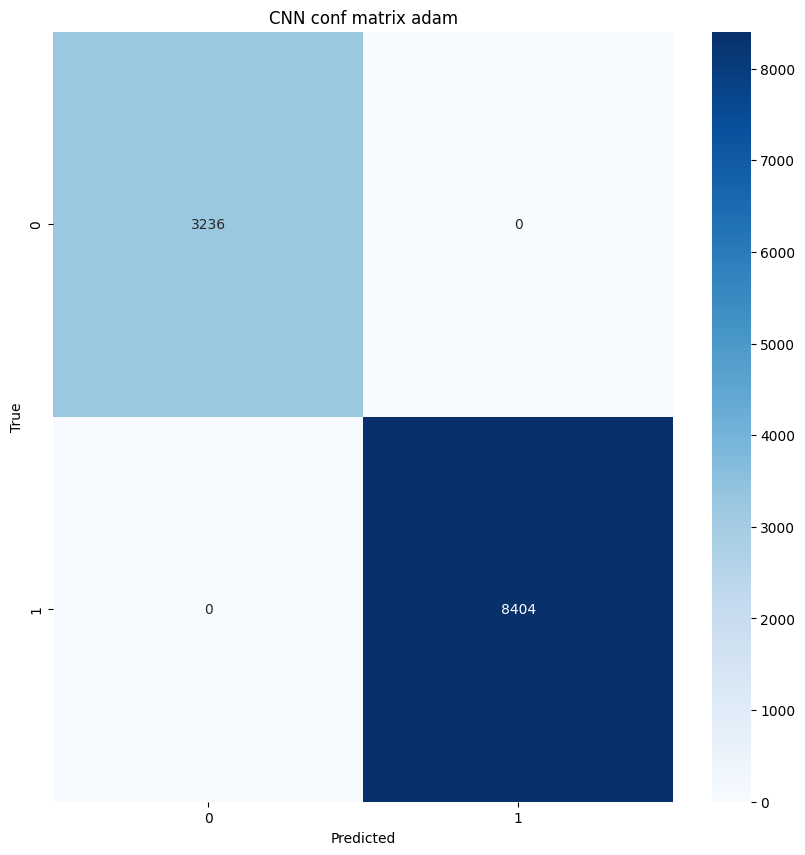

In [8]:
plot_confussion_matrix(predictions, labels, save_path=save_paths.pop())

Train Loss CNN Patients adam


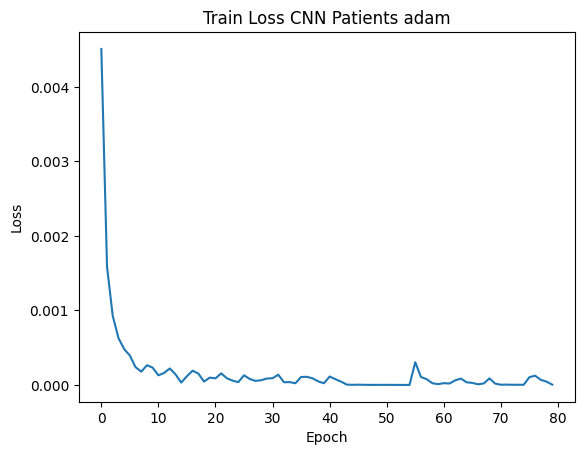

In [9]:
plot_loss(train_losses, save_path=save_paths.pop())

## MLP ECG

In [10]:
# Create an instance of the model
classifier = MLP(187, 2).to(device)
myTrainerMLP = MyTrainer(
    classifier,
    train_loader,
    train_dataset,
    test_loader,
    test_dataset,
    **EXTRA_TRAINER_PARAMS
)
best_model_wts, train_losses = myTrainerMLP.train_model()

Epoch 10/80
----------
epoch train loss: 0.0017 Acc: 95.5928
Epoch 20/80
----------
epoch train loss: 0.0007 Acc: 98.3763
Epoch 30/80
----------
epoch train loss: 0.0006 Acc: 98.7715
Epoch 40/80
----------
epoch train loss: 0.0003 Acc: 99.3900
Epoch 50/80
----------
epoch train loss: 0.0003 Acc: 99.3299
Epoch 60/80
----------
epoch train loss: 0.0003 Acc: 99.4502
Epoch 70/80
----------
epoch train loss: 0.0001 Acc: 99.7423
Epoch 80/80
----------
epoch train loss: 0.0001 Acc: 99.7938


In [11]:
myTrainerMLP.load_wts(best_model_wts)
predictions, labels = myTrainerMLP.test_model()

In [12]:
accuraccy, precision, recall, f1 = myTrainerCNN.metrics_calculator(predictions, labels)
print(f"Accuracy: {accuraccy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9998281786941581
Precision: 0.9998281786941581
Recall: 0.9998281786941581
F1 Score: 0.9998281786941581


MLP ECG conf matrix adam


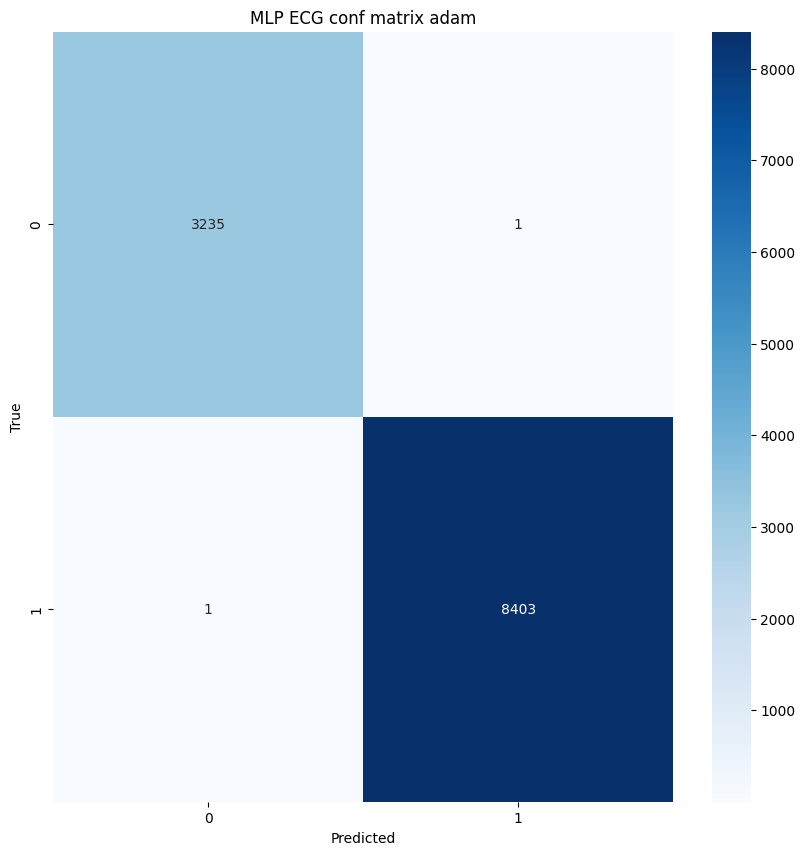

In [13]:
plot_confussion_matrix(predictions, labels, save_path=save_paths.pop())

Train Loss MLP ECG adam


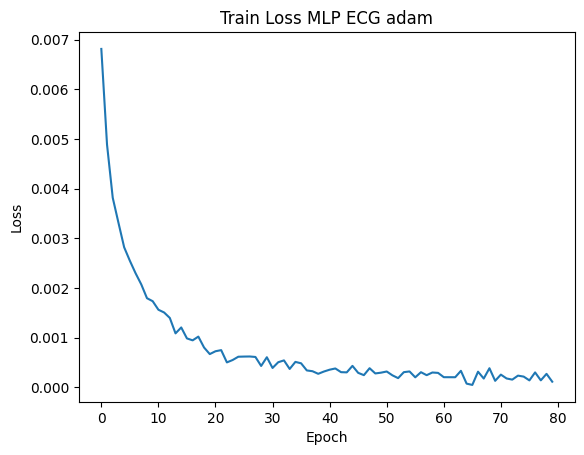

In [14]:
plot_loss(train_losses, save_path=save_paths.pop())

## ECG PATIENTS

In [15]:
X_train, X_test, y_train, y_test = get_train_test_tensors()
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

Features removed: {'Smoker', 'Calorie_monitoring'}
Features removed: {'Sedentary_hours_daily', 'Est_avg_calorie_intake'}


In [16]:
in_features = X_train.shape[1]
out_features = len(torch.unique(y_train))
classifer = MLP(in_features, out_features).to(device)
myTrainerMLP_patients = MyTrainer(
    classifer,
    train_loader,
    train_dataset,
    test_loader,
    test_dataset,
    **EXTRA_TRAINER_PARAMS
)
best_model_wts, train_losses  = myTrainerMLP_patients.train_model()

Epoch 10/80
----------
epoch train loss: 0.0048 Acc: 90.1042
Epoch 20/80
----------
epoch train loss: 0.0010 Acc: 98.3073
Epoch 30/80
----------
epoch train loss: 0.0002 Acc: 99.6745
Epoch 40/80
----------
epoch train loss: 0.0010 Acc: 97.6562
Epoch 50/80
----------
epoch train loss: 0.0000 Acc: 99.9349
Epoch 60/80
----------
epoch train loss: 0.0000 Acc: 99.9349
Epoch 70/80
----------
epoch train loss: 0.0000 Acc: 99.9349
Epoch 80/80
----------
epoch train loss: 0.0000 Acc: 99.9349


In [17]:
# Test the model
myTrainerMLP_patients.load_wts(best_model_wts)
predictions, labels = myTrainerMLP_patients.test_model()

In [18]:
accuraccy, precision, recall, f1 = myTrainerMLP_patients.metrics_calculator(
    predictions, labels
)
print(f"Accuracy: {accuraccy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9993489583333334
Precision: 0.9993519176136364
Recall: 0.9993489583333334
F1 Score: 0.9993489266300183


MLP Patients conf matrix adam


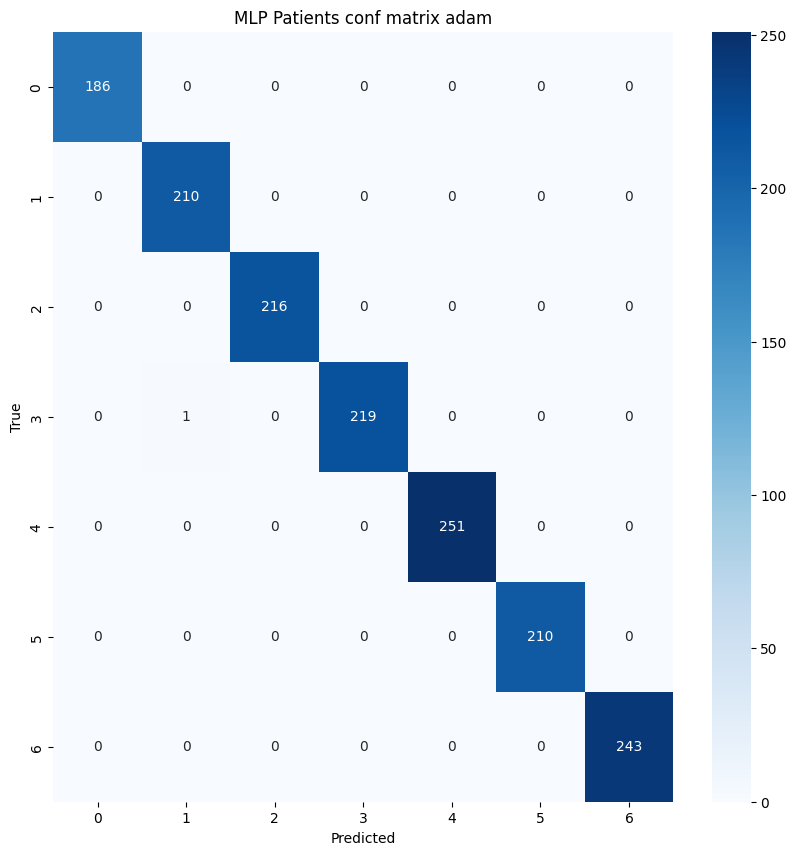

In [19]:
# Confusion matrix
plot_confussion_matrix(predictions, labels, save_path=save_paths.pop())

Train Loss MLP Patients adam


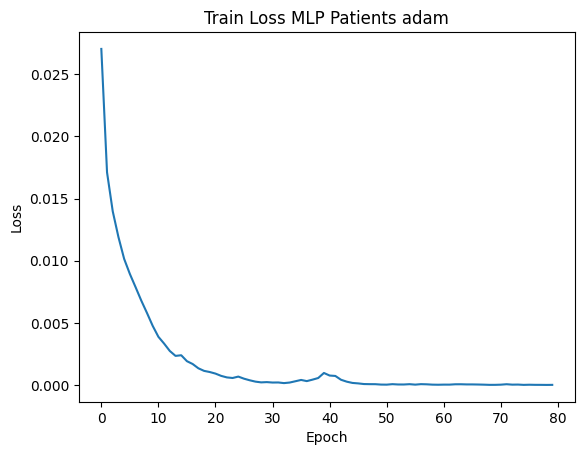

In [20]:
# Plot Train Loss
plot_loss(train_losses, save_path=save_paths.pop())